<a href="https://colab.research.google.com/github/WellFan/bayesian_with_merchants/blob/main/merchants_goods_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import stats
import stan
import arviz as az
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

Consider the following model:
<br/>
$\mu_i \sim Beta(\alpha_u, \beta_u)$
<br/>
$trial_i \sim 10*Exp(10) = Gamma(10,10)$
<br/>
With parameter tranformation:
<br/>
$\alpha_i=\mu_i*trial_i\qquad \beta_i=(1-\mu_i)*trial_i$
<br/>
The relation between datas and parameters:
<br/>
$ctr_{ij} \sim Beta(\alpha_i, \beta_i)$
<br/>
$click_{ij} \sim Bin(impression_{ij}, ctr_{ij})$

Let i denote the i'th merchant, let (i,j) denote the j'th kind of goods from i'th merchant

---

In [ ]:
nmerchants = 100
ngoods = np.random.randint(low=1, high=101, size=nmerchants)
alpha_u = 2
beta_u = 98
mu_i = stats.beta.rvs(alpha_u, beta_u, size=nmerchants)
trial = 10*stats.expon.rvs(scale=10, size=nmerchants)
data = np.array(([0], [0], [0], [0]))
for i in range(nmerchants):
  ctr = np.array(stats.beta.rvs(mu_i[i]*trial[i], (1-mu_i[i])*trial[i], size=ngoods[i]))
  impression = np.random.randint(low=1, high=101, size=ngoods[i])
  click = np.array(stats.binom.rvs(impression, ctr))
  merchants_id = np.array([i]*ngoods[i])
  temp = (np.vstack((merchants_id, ctr, impression, click)))
  data = np.hstack((data, temp))
data = np.transpose(data)
data = np.delete(data, 0, 0)

In [ ]:
data = np.delete(data, 0, 0)
data.shape

(4972, 4)

In [ ]:
text='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  vector<lower=0>[M] trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu.*trial;
  beta_i = (1-mu).*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 10);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df = fit.to_frame()

Building...



Building: 56.1s, done.Messages from stanc:
Warning in '/tmp/httpstan_t4ugl8rw/model_2pg7jg65.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_t4ugl8rw/model_2pg7jg65.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_t4ugl8rw/model_2pg7jg65.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [ ]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-25758.602915,0.947368,0.162583,4.0,19.0,1.0,25847.995520,0.069441,0.055523,0.036214,...,1.736770,1.153184,2.100219,1.584902,1.666794,1.862295,1.009527,2.012876,3.052622,1.371662
1,-25771.636250,0.893165,0.162583,5.0,31.0,0.0,25871.549393,0.102217,0.063787,0.036226,...,1.368862,0.512094,2.338929,1.410123,1.024583,1.480706,1.576253,1.896312,2.094677,1.376546
2,-25779.765857,0.789445,0.162583,5.0,31.0,0.0,25871.663834,0.124357,0.029249,0.023871,...,1.066444,1.047918,0.749793,1.286104,1.570940,2.639911,0.804195,1.243282,2.339557,0.815576
3,-25769.895691,0.991656,0.162583,5.0,31.0,0.0,25885.671211,0.110213,0.033905,0.059385,...,1.388738,0.514319,2.177895,1.521259,1.088807,1.800126,1.410991,1.817405,1.741723,1.347446
4,-25766.330842,0.971834,0.162583,5.0,31.0,0.0,25872.246651,0.090984,0.039422,0.028585,...,0.899240,0.756136,0.774749,1.564095,1.163935,2.655971,0.844164,1.302124,1.883139,1.082397


---

After the estimation, Stan brings lots of draws of $\hat{\alpha}_u, \hat{\beta}_u, \hat{\mu}_i, \hat{trial}_i$  
And from sample distribution  

$\hat{\alpha}_u \stackrel{p}{\to} \alpha_u$  
$\hat{\beta}_u \stackrel{p}{\to} \beta_u$  
$\bar{\hat{\mu}_i}\stackrel{d}{\to} \mu_i \sim Beta(\alpha_u, \beta_u)$  
$\bar{\hat{trial}_i}\stackrel{d}{\to} trial_i \sim Gamma(10, 10)$

---

In [ ]:
df.iloc[:,107:207].mean()

parameters
trial.1      3.523892
trial.2      0.644532
trial.3      1.058686
trial.4      1.456824
trial.5      1.687551
               ...   
trial.96     2.104656
trial.97     1.158094
trial.98     1.620498
trial.99     2.152180
trial.100    1.123201
Length: 100, dtype: float64

In [ ]:
alpha_u = df['alpha_u']
beta_u = df['beta_u']
mu = df.iloc[:,7:107]
trial = df.iloc[:,107:207]
alpha_i = df.iloc[:, 209:309]
beta_i = df.iloc[:, 309:409]

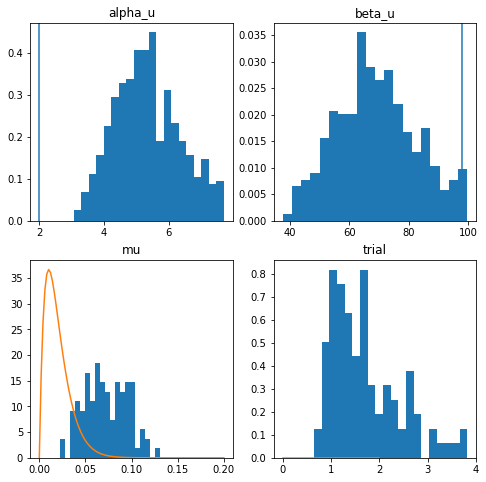

In [ ]:
points = np.linspace(0, 100, 1001, endpoint=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].set_title('alpha_u')
axes[0,0].hist(alpha_u, density=True, bins=20)
axes[0,0].axvline(2)
axes[0,1].set_title('beta_u')
axes[0,1].hist(beta_u, density=True, bins=20)
axes[0,1].axvline(98)
axes[1,0].set_title('mu')
axes[1,0].hist(mu.mean(), density=True, bins=20)
axes[1,0].plot(np.linspace(0, 0.2, 100), stats.beta.pdf(np.linspace(0, 0.2, 100), 2, 98))
axes[1,1].set_title('trial')
axes[1,1].hist(trial.mean(), density=True, bins=20)
axes[1,1].plot(np.linspace(0, 2, 100), stats.gamma.pdf(np.linspace(0, 2, 100), 10, 10))

From the figure above, we can see the model is not doing well.  
We then study the difference between estimated ctr and the true one. 


In [ ]:
customer_stan = pd.DataFrame(data, columns=['merchant_id', 'ctr', 'impression', 'click'])
customer_stan = customer_stan.astype({'merchant_id':int, 'impression':int, 'click':int})
customer_stan.head()

,merchant_id,ctr,impression,click
0,0,0.044292,28,3
1,0,0.009286,95,1
2,0,0.069617,83,7
3,0,0.118768,76,11
4,0,0.037322,96,4


In [ ]:
customer_stan['alpha_i'] = alpha_i.mean()[customer_stan.merchant_id][1]
customer_stan['beta_i'] = beta_i.mean()[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_stan = lambda df:(df.click+df.alpha_i)/(df.impression+df.alpha_i+df.beta_i))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan
0,0,0.044292,28,3,0.341017,3.182875,0.105984
1,0,0.009286,95,1,0.341017,3.182875,0.013611
2,0,0.069617,83,7,0.341017,3.182875,0.084844
3,0,0.118768,76,11,0.341017,3.182875,0.142611
4,0,0.037322,96,4,0.341017,3.182875,0.043618


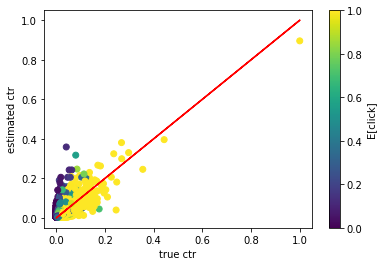

In [ ]:
plt.scatter(customer_stan.ctr, customer_stan.avg_stan, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('estimated ctr')
plt.colorbar(label='E[click]')
plt.show()

In [ ]:
customer_stan.ctr.corr(customer_stan.avg_stan)

0.7457415222920641

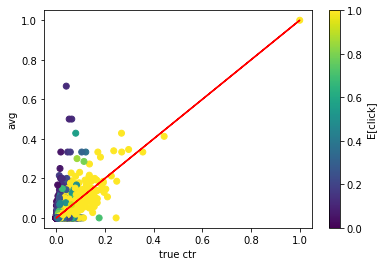

In [ ]:
plt.scatter(customer_stan.ctr, customer_stan.click/customer_stan.impression, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('avg')
plt.colorbar(label='E[click]')
plt.show()

---

Figure 1&2 compares tradional way to compute the ctr with the bayesian way.  
The bayesian does better esimate the ctr when the expectation is low.  
Intuitively, the prior that baysian gives makes a better fit when our observations is rather low.  
Hence we have a default belief about how the good is when we see a new kind.

---

If we neglect the difference between merchants:  
$ctr_i\sim Betabinom(impression_i, \alpha, \beta)$

---

In [ ]:
text2='''
data{
  int<lower=0> N;
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  real<lower=0> alpha;
  real<lower=0> beta;
}
model{
  alpha~uniform(0.01, 100);
  beta~uniform(0.01, 100);
  click~beta_binomial(impression, alpha, beta);
}
'''
stan_data = {'N':data.shape[0], 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text2, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_nomerchant = fit.to_frame()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_85wt7f22/model_3h7uqfuw.stan', line 13, column 21: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_85wt7f22/model_3h7uqfuw.stan', line 13, column 15: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_85wt7f22/model_3h7uqfuw.stan', line 13, column 2: Parameter beta is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constr

In [ ]:
df_nomerchant.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta
draws,,,,,,,,,
0,-23689.375249,0.947620,0.35136,2.0,3.0,0.0,23689.472452,0.628271,29.168518
1,-23689.269157,0.962034,0.35136,2.0,7.0,0.0,23690.824527,0.634011,30.182413
2,-23689.352142,0.990738,0.35136,2.0,7.0,0.0,23689.386309,0.637194,29.589436
3,-23689.846428,0.847705,0.35136,2.0,7.0,0.0,23691.009305,0.616694,29.729822
4,-23690.560325,0.823717,0.35136,1.0,1.0,0.0,23690.685432,0.610737,29.767803


In [ ]:
alpha_true = df_nomerchant.alpha.mean()
beta_true = df_nomerchant.beta.mean()
customer_stan = customer_stan.assign(avg_bayesian = lambda df:(df.click+alpha_true)/(df.impression+alpha_true+beta_true))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian
0,0,0.044292,28,3,0.341017,3.182875,0.105984,0.062062
1,0,0.009286,95,1,0.341017,3.182875,0.013611,0.013030
2,0,0.069617,83,7,0.341017,3.182875,0.084844,0.067226
3,0,0.118768,76,11,0.341017,3.182875,0.142611,0.109166
4,0,0.037322,96,4,0.341017,3.182875,0.043618,0.036625


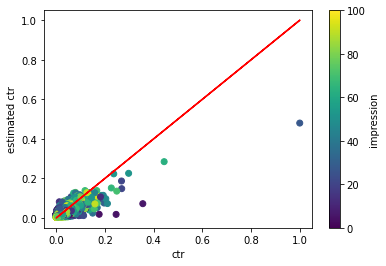

In [ ]:
plt.scatter(customer_stan.ctr, customer_stan.avg_bayesian, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.xlabel('ctr')
plt.ylabel('estimated ctr')
plt.show()

---

The estimator is fitted as well as different merchants model 

---

---

Consider another model where merchants difference exists but with same trial, which is called beta-binomial regression:
<br/> 
$\mu_i \sim Beta(\alpha_u, \beta_u)$
<br/>
$trial_i = C \qquad ∀i$
<br/>
With parameter tranformation:
<br/>
$\alpha_i=\mu_i*C\qquad \beta_i=(1-\mu_i)*C$
<br/>
The relation between datas and parameters:
<br/>
$ctr_{ij} \sim Beta(\alpha_i, \beta_i)$
<br/>
$click_{ij} \sim Bin(impression_{ij}, ctr_{ij})$

---

In [ ]:
text3='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  real<lower=0> trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu*trial;
  beta_i = (1-mu)*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 10);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text3, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_same_trial = fit.to_frame()

Building...



Building: 42.0s, done.Messages from stanc:
Warning in '/tmp/httpstan_f_0xe3v4/model_ap3nvxuq.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_f_0xe3v4/model_ap3nvxuq.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_f_0xe3v4/model_ap3nvxuq.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [ ]:
df_same_trial.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-23592.177149,0.847899,0.178654,3.0,11.0,1.0,23650.005002,0.048106,0.010263,0.011064,...,22.253709,22.360658,21.892784,22.062536,21.633808,22.191875,21.872779,22.189134,22.096612,22.076364
1,-23598.561369,0.916087,0.178654,3.0,12.0,1.0,23647.195316,0.042316,0.010371,0.012960,...,22.507746,22.592691,22.184108,22.499532,22.076949,22.444032,22.136398,22.515443,22.394521,22.409265
2,-23593.839410,0.866727,0.178654,3.0,10.0,1.0,23651.755973,0.044837,0.010282,0.012720,...,22.246289,22.300338,21.889056,22.243527,21.547070,22.086120,21.996623,22.159987,22.058545,22.251165
3,-23594.908290,0.854521,0.178654,4.0,28.0,1.0,23648.418241,0.039147,0.011771,0.010822,...,22.912108,22.969916,22.763005,22.684327,21.959416,22.738773,22.766501,22.913804,22.625874,22.828334
4,-23604.574042,0.734860,0.178654,2.0,6.0,1.0,23654.700435,0.038421,0.013121,0.010988,...,22.782811,22.775840,22.584841,22.556567,21.252274,22.604068,22.590971,22.575887,22.546159,22.588276


In [ ]:
mu2 = df_same_trial.iloc[:,7:107].mean()
alpha_proun = df_same_trial.iloc[:,107].mean()*mu2
beta_proun = df_same_trial.iloc[:,107].mean()-alpha_proun

In [ ]:
customer_stan['alpha_proun'] = alpha_proun[customer_stan.merchant_id][1]
customer_stan['beta_proun'] = beta_proun[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_uni_trial = lambda df:(df.click+df.alpha_proun)/(df.impression+df.alpha_proun+df.beta_proun))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian,alpha_proun,beta_proun,avg_uni_trial
0,0,0.044292,28,3,0.341017,3.182875,0.105984,0.062062,1.016702,20.954195,0.080381
1,0,0.009286,95,1,0.341017,3.182875,0.013611,0.013030,1.016702,20.954195,0.017241
2,0,0.069617,83,7,0.341017,3.182875,0.084844,0.067226,1.016702,20.954195,0.076371
3,0,0.118768,76,11,0.341017,3.182875,0.142611,0.109166,1.016702,20.954195,0.122656
4,0,0.037322,96,4,0.341017,3.182875,0.043618,0.036625,1.016702,20.954195,0.042525


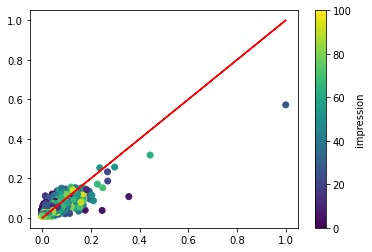

In [ ]:
plt.scatter(customer_stan.ctr, customer_stan.avg_uni_trial, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.show()

---

This model is fitted quite good as well.

---